In [99]:
import psycopg2
import pandas as pd

db_endpoint = "postgres-1.clmlqirmvrik.eu-central-1.rds.amazonaws.com"
db_port = 5432
db_name = "OPA_project"
db_user = "postgres"
db_password = "datascientest"

# Parameters
param_dic = {
    "host"      : db_endpoint,
    "database"  : db_name,
    "user"      : db_user,
    "password"  : db_password,
    "port"      : db_port
}

def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn

def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tuples
    tuples = cursor.fetchall()
    cursor.close()
    
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tuples, columns=column_names)
    return df

# Connect to the database
conn = connect(param_dic)


Connecting to the PostgreSQL database...
Connection successful


In [117]:
column_names = ["date", "open", "high", "low", "close", "adjclose", "volume", "ticker", "currency_id"]
# Execute the "SELECT *" query

df = postgresql_to_dataframe(conn, "select * from crypto_daily_rates_hist", column_names = column_names)

In [118]:
df.columns
cols_float = ["open", "high", "low", "close", "adjclose", "volume"]

for col in cols_float:
    df[col] = df[col].astype(float)

df["ticker"] = df["ticker"] .astype(str)
df["currency_id"] = df["currency_id"] .astype(str)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         4072 non-null   datetime64[ns]
 1   open         4052 non-null   float64       
 2   high         4052 non-null   float64       
 3   low          4052 non-null   float64       
 4   close        4052 non-null   float64       
 5   adjclose     4052 non-null   float64       
 6   volume       4052 non-null   float64       
 7   ticker       4072 non-null   object        
 8   currency_id  4072 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 286.4+ KB


,date,open,high,low,close,adjclose,volume,ticker,currency_id
0,2023-01-01,16547.914062,16630.439453,16521.234375,16625.080078,16625.080078,9.244362e+09,btc-usd,btc
1,2023-01-02,16625.509766,16759.343750,16572.228516,16688.470703,16688.470703,1.209778e+10,btc-usd,btc
2,2023-01-03,16688.847656,16760.447266,16622.371094,16679.857422,16679.857422,1.390308e+10,btc-usd,btc
3,2023-01-04,16680.205078,16964.585938,16667.763672,16863.238281,16863.238281,1.842174e+10,btc-usd,btc
4,2023-01-05,16863.472656,16884.021484,16790.283203,16836.736328,16836.736328,1.369276e+10,btc-usd,btc


In [150]:
df_btc = df[df["ticker"]=="btc-usd"]


In [151]:
# convert date into index
df_btc.set_index('date', inplace = True)
# drop NA
df_btc = df_btc.dropna()

# drop irreleant columns
df_btc.drop('ticker', axis=1, inplace=True)
df_btc.drop('currency_id', axis=1, inplace=True)
df_btc.drop('adjclose', axis=1, inplace=True)

In [152]:
### adding more coloumns (in an attempt to provide the algo with more relevant data, aka feature engineering)

# moving avg 20 vs moving avg 50 
df_btc['ma20vsma50'] =  df_btc['close'].rolling(window=10).mean() / df_btc['close'].rolling(window=25).mean()

# daily delta (closing - opening) / closing
df_btc['dailydelta'] =  (df_btc['close'] - df_btc['open'] ) / df_btc['close']

# volatility (high - low) / closing
df_btc['volatility'] =  abs((df_btc['high'] - df_btc['low'] ) / df_btc['close'])


In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

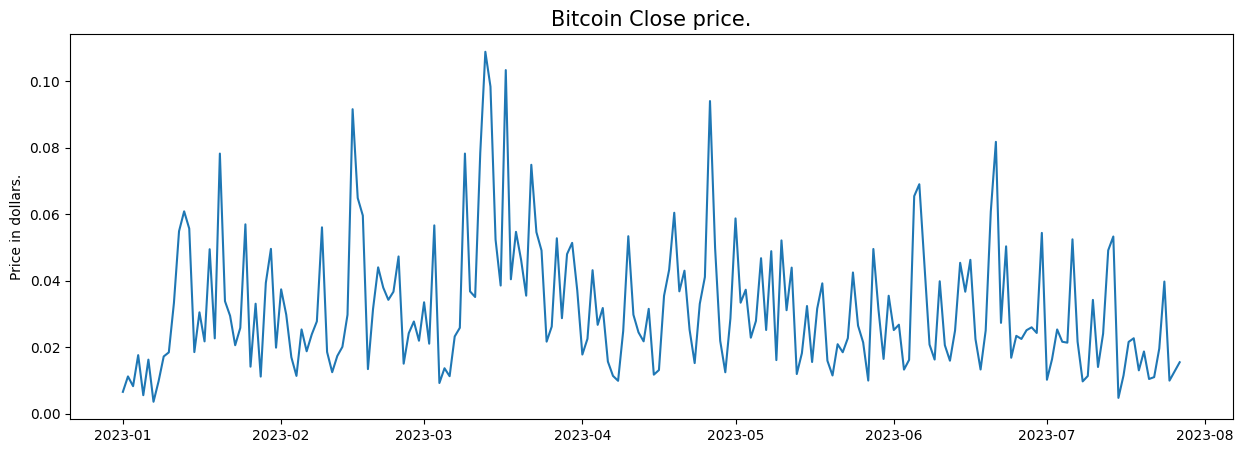

In [154]:
plt.figure(figsize=(15, 5))
#plt.plot(df_btc['close'])
#plt.plot(df_btc['ma20vsma50'])
plt.plot(df_btc['volatility'])

plt.title('Bitcoin Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

In [155]:
### creating target label

# threshold 1% in order to filter out small changes
upper_threshold = 0.01
lower_threshold = -0.01

# change close comared to -3 days
percentage_change = df_btc['close'].shift(-3) / df_btc['close'] - 1
df_btc['target'] = np.where(percentage_change > upper_threshold, 1,
                            np.where(percentage_change < lower_threshold, -1, 0))

num_classes = 3  # Number of discrete classes
#df_btc['target'] = pd.qcut(df_btc['target'], q=num_classes, labels=False, duplicates='drop')

df_btc['target'] = pd.cut(df_btc['target'], bins=num_classes, labels=False)


In [156]:
df_btc['target'].value_counts()

target
2    76
1    67
0    64
Name: count, dtype: int64

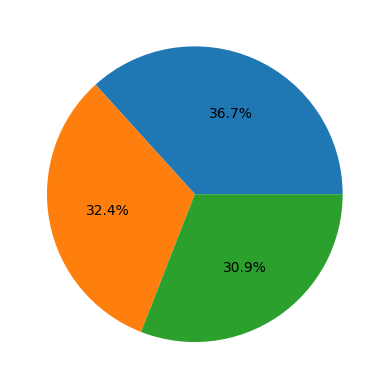

In [147]:
plt.pie(df_btc['target'].value_counts().values, autopct='%1.1f%%')
plt.show()

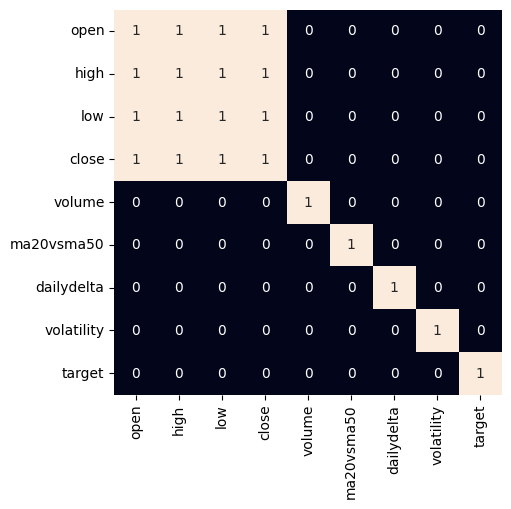

In [157]:
plt.figure(figsize=(5, 5))

# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sb.heatmap(df_btc.corr() > 0.85, annot=True, cbar=False)
plt.show()

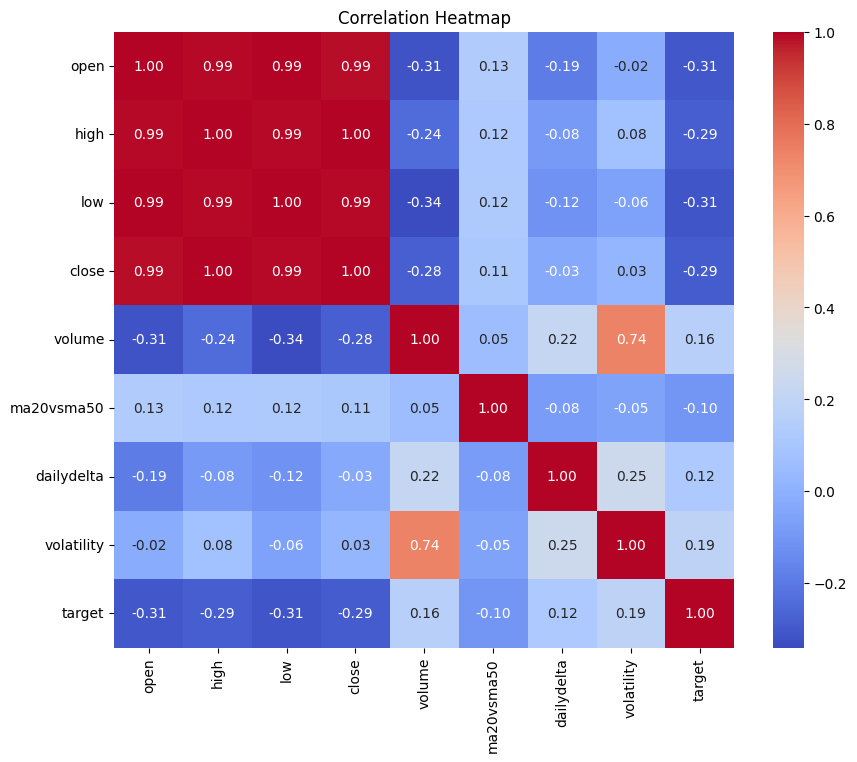

In [158]:
# different corr matrix
correlation_matrix = df_btc.corr()
# Create a heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [159]:
# open, volume, volatility seem to be good signals

features = df_btc[['volume', 'volatility', 'open', 'dailydelta', 'ma20vsma50']]
target = df_btc['target']

#scaler = StandardScaler()
#features = scaler.fit_transform(features)



X_train, X_test, Y_train, Y_test = train_test_split(
	features, target, test_size=0.2, random_state=2022)

print(X_train.shape, X_test.shape)


(165, 5) (42, 5)


In [160]:
# models = [LogisticRegression(), SVC(kernel='linear', probability=True), XGBClassifier()]

models = XGBClassifier()

models.fit(X_train, Y_train)

print('Training Accuracy : ', metrics.accuracy_score(Y_train, models.predict_proba(X_train)[:,1]))
print('Validation Accuracy : ', metrics.accuracy_score(Y_test, models.predict_proba(X_test)[:,1]))





ValueError: Classification metrics can't handle a mix of multiclass and continuous targets